In [27]:
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
path = Path('./travel_insurance/')

Train = pd.read_csv(path/'train.csv')
Test = pd.read_csv(path/'test.csv')

In [4]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer Id          1590 non-null   object
 1   Age                  1590 non-null   int64 
 2   Employment Type      1590 non-null   object
 3   GraduateOrNot        1590 non-null   object
 4   AnnualIncome         1590 non-null   int64 
 5   FamilyMembers        1590 non-null   int64 
 6   ChronicDiseases      1590 non-null   int64 
 7   FrequentFlyer        1590 non-null   object
 8   EverTravelledAbroad  1590 non-null   object
 9   TravelInsurance      1590 non-null   object
dtypes: int64(4), object(6)
memory usage: 124.3+ KB


In [5]:
train.head()

,Customer Id,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
555,SV444B5KLI58,28,Private Sector/Self Employed,Yes,750000,3,0,No,No,No
1058,BPPOTMP5VP0W,33,Government Sector,Yes,400000,6,0,No,No,Yes
4,2WGFUEX6IEHM,34,Private Sector/Self Employed,Yes,700000,4,1,No,No,No
1052,6ZWJFDABTT19,25,Private Sector/Self Employed,Yes,1400000,8,0,No,Yes,Yes
403,WO7SU04ON7X1,35,Private Sector/Self Employed,No,800000,5,0,No,No,Yes


(array([46., 60., 51., 78., 42., 61., 66., 38., 20., 15.]),
 array([ 300000.,  450000.,  600000.,  750000.,  900000., 1050000.,
        1200000., 1350000., 1500000., 1650000., 1800000.]),
 <BarContainer object of 10 artists>)

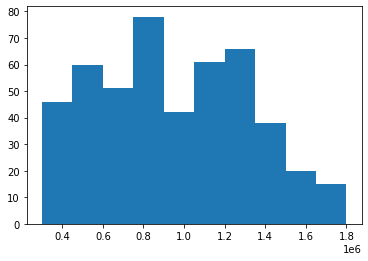

In [62]:
plt.hist(train['AnnualIncome'])

In [6]:
# Solution to `Exploration - Insurance`
# Part 1_1
nrow, ncol = len(Train), len(Train.columns)
print(f"{nrow} {ncol}")
# Part 1_2
print(int(Train['AnnualIncome'].sum()/nrow))
# Part 1_3
print( (Train['EverTravelledAbroad']=='Yes').sum())
# Part 1_4
gk = Train.groupby('Employment Type')
govSect, priSect = len(gk.groups['Government Sector']), len(gk.groups['Private Sector/Self Employed'])
if  govSect>priSect:
    secPercent =  govSect/nrow
    title = 'Goverment Sector'
else:
    secPercent = priSect/nrow
    title = 'Private Sector/Self Employed'
print(f"{title} {secPercent*100:.2f}")
# Part 1_5
diseasesTravelIns = ((Train[Train['ChronicDiseases']==1])['TravelInsurance']=='Yes').sum()
print( f"{diseasesTravelIns/nrow*100:.2f}" )


1590 10
928553
302
Private Sector/Self Employed 72.64
10.50


In [35]:
le = LabelEncoder().fit(['Yes', 'No'])

def PreProcessing(df, train=False):
    df = df.copy()
    df["Employment Type"] = df["Employment Type"].apply(lambda x: "Yes" if x=="Private Sector/Self Employed" else "No")
    cols = ["GraduateOrNot", "EverTravelledAbroad", "FrequentFlyer", "Employment Type"]
    if train:
        cols.append("TravelInsurance")
    for col in cols:
        df[col] = le.transform(df[col])
    return df

In [42]:
def drawROC(yhat, yval, modelname):
    # generate a no skill prediction (majority class)
    ns_probs = [1 for _ in range(len(yhat))]
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(yval, ns_probs)
    rl_auc = roc_auc_score(yval, yhat)
    # summarize scores
    print(f"No Skill: ROC AUC={ns_auc:.3g}")
    print(f"{modelname}: ROC AUC={rl_auc:.3g}")
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
    fpr, tpr, _ = roc_curve(y_val, yhat)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=modelname)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

No Skill: ROC AUC=0.5
Random Forest: ROC AUC=0.831


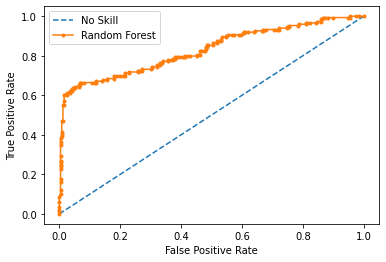

In [59]:
df = PreProcessing(Train, train=True)
X, y = df[["Age","Employment Type","GraduateOrNot","AnnualIncome","FamilyMembers", "ChronicDiseases",
        "FrequentFlyer","EverTravelledAbroad"]] , df["TravelInsurance"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.25)

model = RandomForestClassifier(n_estimators=400, random_state=14, max_depth=12, criterion='entropy')
model.fit(X_train,y_train)

# predict probabilities
yhat = model.predict_proba(X_val)

drawROC(yhat, y_val, 'Random Forest')

In [65]:
cols = ["Age","Employment Type","GraduateOrNot","AnnualIncome","FamilyMembers","ChronicDiseases",
        "FrequentFlyer","EverTravelledAbroad"]
test = PreProcessing(Test)
yhat = clf.predict_proba(test[cols])

newdf = pd.concat([test['Customer Id'], pd.Series(yhat[:,1])], axis=1, keys=['Customer Id', 'prediction'])
newdf.to_csv('output2.csv', index=False)
newdf

,Customer Id,prediction
0,Q5OK4L2Q5XNH,0.898532
1,CBHVMVE7TRP5,1.000000
2,9UGHQ91U4F0M,0.323345
3,3UWXWMZK4ZGL,0.982500
4,5CGEMLMBOPES,0.089534
...,...,...
392,3T4IU1ZJNDIA,0.457060
393,N3ON6CQWDU4Z,0.494338
394,LWW08WASNJ2T,0.086704
395,L2RAKTUJP4HS,0.015292
